# Short Term Load Forecasting Part 3 

- Coded using Python 3.8
- Load data consists of univariate timeseries representing energy consumption from 2017-10-01 to 2018-08-31
- Energy Consumption has a sample rate of 1 sample every 15 minutes
- For the ease of use and material knowledge, assuming the load to be kWh
- Exogenous variables introduced by viewing holidays as separate load profiles

In [77]:
### IMPORTING ALL THE REQUIRED LIBRARIES ###

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [312]:
### READING DATA FROM THE FOLDER NAMED DATA. THE MAIN DATA FILE IS NAMED AS load.csv ###

data = pd.read_csv('data/load.csv',index_col=[0], parse_dates=[0])
data.head()

,load
date,
2017-10-01 00:00:00,60.626609
2017-10-01 00:15:00,61.020288
2017-10-01 00:30:00,59.839250
2017-10-01 00:45:00,60.823449
2017-10-01 01:00:00,57.477175


In [280]:
### Foe a better understanding of load profiling, I am analyzing the load as separate profiles with minutes/hours/days of the week

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['minutes'] = df['date'].dt.minute
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['minutes','hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data, label='load')

features_and_target = pd.concat([X, y], axis=1)

<ipython-input-280-0f2b58b8879d>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [281]:
# See our features and target
features_and_target.head()

,minutes,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,load
date,,,,,,,,,,
2017-10-01 00:00:00,0,0,6,4,10,2017,274,1,39,60.626609
2017-10-01 00:15:00,15,0,6,4,10,2017,274,1,39,61.020288
2017-10-01 00:30:00,30,0,6,4,10,2017,274,1,39,59.839250
2017-10-01 00:45:00,45,0,6,4,10,2017,274,1,39,60.823449
2017-10-01 01:00:00,0,1,6,4,10,2017,274,1,39,57.477175


- Plotting the Features to see trends
- Power demand has strong daily and seasonal properties.
- Day of week also seems to show differences in peaks

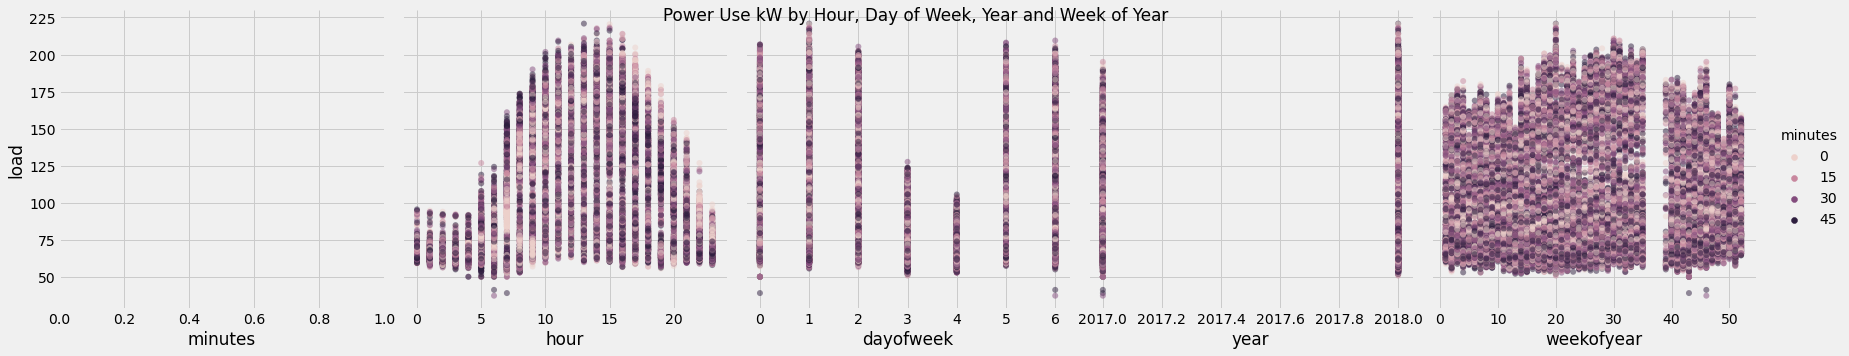

In [282]:
sns.pairplot(features_and_target.dropna(),
             hue='minutes',
             x_vars=['minutes','hour','dayofweek',
                     'year','weekofyear'],
             y_vars='load',
             height=5,
             plot_kws={'alpha':0.5, 'linewidth':0}
            )
plt.suptitle('Power Use kW by Hour, Day of Week, Year and Week of Year')
plt.show()

## Train/Test Split
- Cut off the data after August 30st (since we need to perform a 24 hour ahead forecasting) to use as our validation set. 
- We will train on earlier data.

In [283]:
split_date = '08/31/2018'
train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()

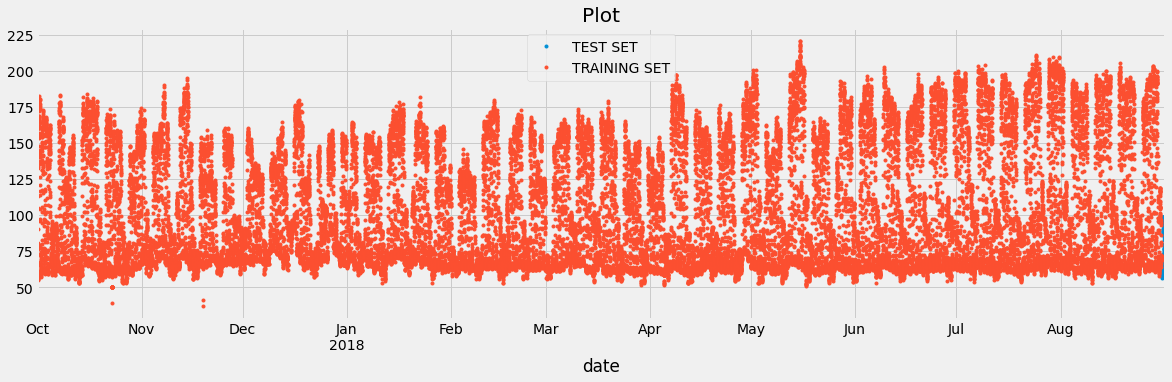

In [285]:
# Plot train and test so you can see where we have split
### since the size of testing data is significanlty small (24 hours), it is not visiblt clearly on the plot ###
### we can make it a scrollable interactive plot using plotly as seen in Part 2 ###

test \
    .rename(columns={'load': 'TEST SET'}) \
    .join(train.rename(columns={'load': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(18,5), title='Plot', style='.')
plt.show()

## Simple Prophet Model

- Prophet modelrequired that the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [286]:
# Format data for prophet model using ds and y
train.reset_index() \
    .rename(columns={'date':'ds',
                     'load':'y'}).head()

,ds,y
0,2017-10-01 00:00:00,60.626609
1,2017-10-01 00:15:00,61.020288
2,2017-10-01 00:30:00,59.839250
3,2017-10-01 00:45:00,60.823449
4,2017-10-01 01:00:00,57.477175


In [287]:
# Setup and train model and fit
model = Prophet()
model.fit(train.reset_index() \
              .rename(columns={'date':'ds',
                               'load':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [288]:
# Predict on training set with model
test_fcst = model.predict(df=test.reset_index() \
                                   .rename(columns={'date':'ds'}))

In [289]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-31 00:15:00,116.033045,12.990545,64.515336,116.033045,116.033045,-77.084912,-77.084912,-77.084912,-36.767203,-36.767203,-36.767203,-40.317709,-40.317709,-40.317709,0.0,0.0,0.0,38.948133
1,2018-08-31 00:30:00,116.033689,10.227712,63.417527,116.033689,116.033689,-77.825353,-77.825353,-77.825353,-37.403500,-37.403500,-37.403500,-40.421853,-40.421853,-40.421853,0.0,0.0,0.0,38.208336
2,2018-08-31 00:45:00,116.034333,13.681705,61.885170,116.034333,116.034333,-78.347507,-78.347507,-78.347507,-37.831263,-37.831263,-37.831263,-40.516244,-40.516244,-40.516244,0.0,0.0,0.0,37.686826
3,2018-08-31 01:00:00,116.034977,10.431527,61.857580,116.034977,116.034977,-78.681793,-78.681793,-78.681793,-38.080972,-38.080972,-38.080972,-40.600821,-40.600821,-40.600821,0.0,0.0,0.0,37.353184
4,2018-08-31 01:15:00,116.035621,12.357184,62.814616,116.035621,116.035621,-78.863435,-78.863435,-78.863435,-38.187905,-38.187905,-38.187905,-40.675530,-40.675530,-40.675530,0.0,0.0,0.0,37.172186


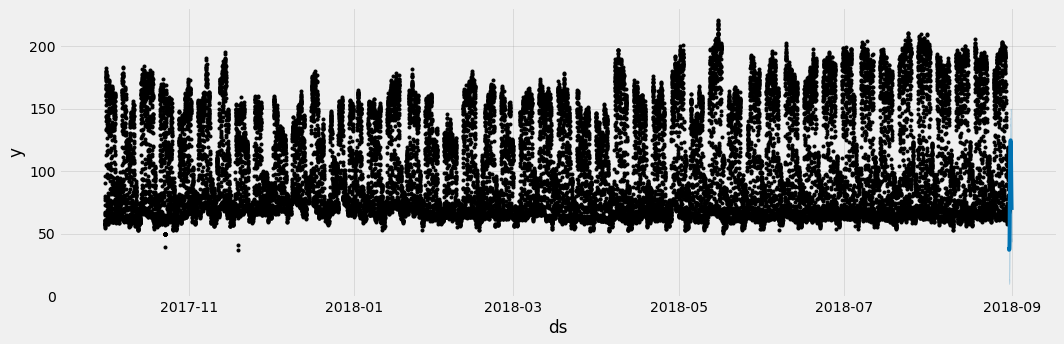

In [290]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

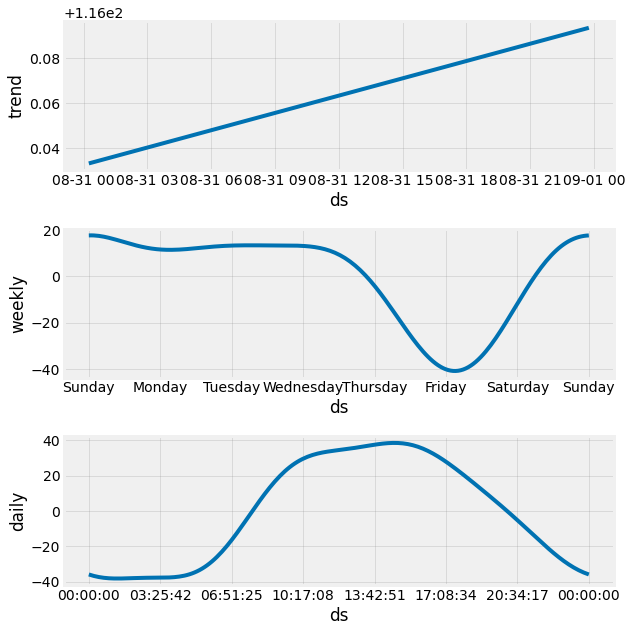

In [291]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

## Compare Forecast to Actuals

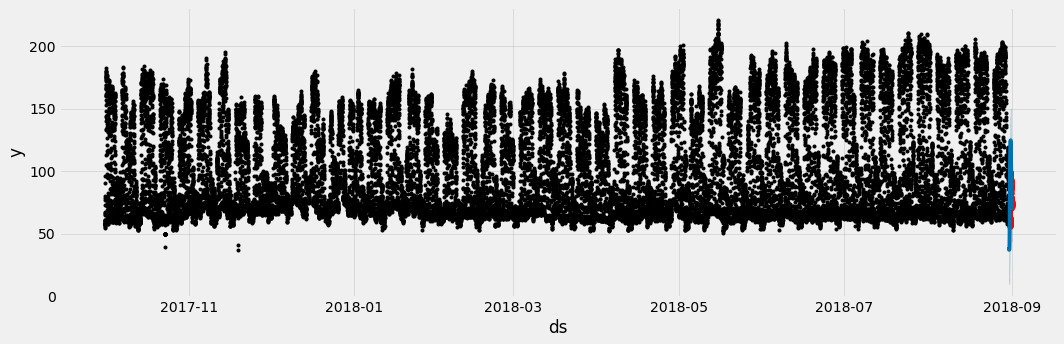

In [292]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['load'], color='r')
fig = model.plot(test_fcst, ax=ax)

## Look at first part of predictions

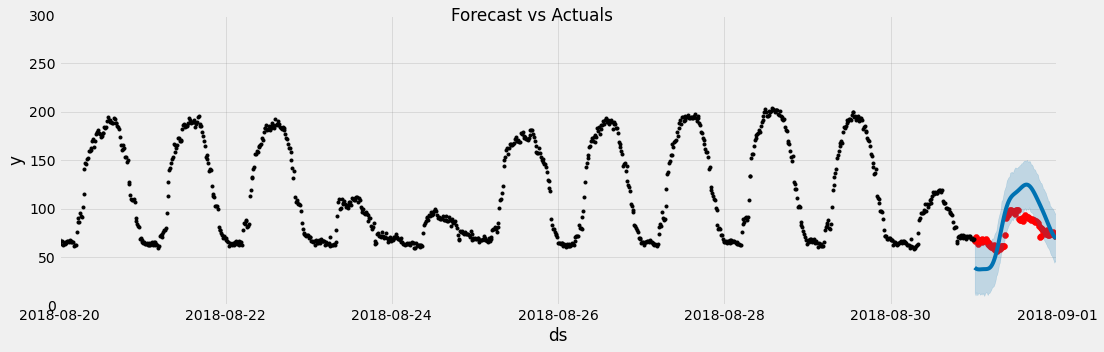

In [319]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['load'], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(lower='2018-08-20',
              upper='2018-09-01')
ax.set_ylim(0, 300)
plot = plt.suptitle('Forecast vs Actuals')

## Error Analysis

- Different Error metrices considered in this case are :

1. Root Mean Squared Error (RMSE) is found to be 546.96
2. Mean Absolute error (MAE) is found to be 21.0764
3. Mean Absolute Percentage Error (MAPE) is about 27.57%

In [320]:
mean_squared_error(y_true=test['load'],
                   y_pred=test_fcst['yhat'])

546.9644524153216

In [295]:
mean_absolute_error(y_true=test['load'],
                   y_pred=test_fcst['yhat'])

21.076438493986743

In [296]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['load'],
                   y_pred=test_fcst['yhat'])

27.576964729203247

## Adding Federal Holidays 

- Load profiles vary based on various factors such as weather, time of the day, weekdays, weekends and holidays.
- In this anlysis, it would be useful to see how much of variance is brought in due to holidays.
- To facilitate a better calender assessment, this analysis uses holidays library.

In [297]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=train.index.min(),
                              end=train.index.max())
test_holidays = cal.holidays(start=test.index.min(),
                             end=test.index.max())

In [298]:
### creating a copy of the dataframe ###
df2=data

In [299]:
# Create a dataframe with holiday, ds columns
df2['dateds'] = df2.index.date
df2['is_holiday'] = df2.dateds.isin([d.date() for d in cal.holidays()])
holiday_df = df2.loc[df2['is_holiday']] \
    .reset_index() \
    .rename(columns={'date':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['load','dateds','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2017-10-09 00:00:00,USFederalHoliday
1,2017-10-09 00:15:00,USFederalHoliday
2,2017-10-09 00:30:00,USFederalHoliday
3,2017-10-09 00:45:00,USFederalHoliday
4,2017-10-09 01:00:00,USFederalHoliday


In [300]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [301]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train.reset_index() \
                            .rename(columns={'date':'ds',
                                             'load':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Predict with holidays

In [302]:
# Predict on training set with model
test_fcst_with_hols = \
    model_with_holidays.predict(df=test.reset_index() \
                                    .rename(columns={'date':'ds'}))

In [321]:
test_fcst_with_hols

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-31 00:15:00,116.038039,14.811420,65.820574,116.038039,116.038039,0.0,0.0,0.0,-77.197319,...,0.0,0.0,0.0,-40.430092,-40.430092,-40.430092,0.0,0.0,0.0,38.840720
1,2018-08-31 00:30:00,116.038672,12.643651,63.124127,116.038672,116.038672,0.0,0.0,0.0,-77.937575,...,0.0,0.0,0.0,-40.534039,-40.534039,-40.534039,0.0,0.0,0.0,38.101097
2,2018-08-31 00:45:00,116.039306,13.720971,59.683458,116.039306,116.039306,0.0,0.0,0.0,-78.459469,...,0.0,0.0,0.0,-40.628156,-40.628156,-40.628156,0.0,0.0,0.0,37.579837
3,2018-08-31 01:00:00,116.039939,12.519156,63.864349,116.039939,116.039939,0.0,0.0,0.0,-78.793419,...,0.0,0.0,0.0,-40.712384,-40.712384,-40.712384,0.0,0.0,0.0,37.246520
4,2018-08-31 01:15:00,116.040572,11.396554,61.577953,116.040572,116.040572,0.0,0.0,0.0,-78.974649,...,0.0,0.0,0.0,-40.786670,-40.786670,-40.786670,0.0,0.0,0.0,37.065923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2018-08-31 22:45:00,116.095042,50.024106,97.411258,116.095042,116.095042,0.0,0.0,0.0,-42.305836,...,0.0,0.0,0.0,-14.452064,-14.452064,-14.452064,0.0,0.0,0.0,73.789205
91,2018-08-31 23:00:00,116.095675,46.054667,97.189368,116.095675,116.095675,0.0,0.0,0.0,-43.852746,...,0.0,0.0,0.0,-13.920817,-13.920817,-13.920817,0.0,0.0,0.0,72.242929
92,2018-08-31 23:15:00,116.096309,45.908855,95.891684,116.096309,116.096309,0.0,0.0,0.0,-45.181084,...,0.0,0.0,0.0,-13.389549,-13.389549,-13.389549,0.0,0.0,0.0,70.915225
93,2018-08-31 23:30:00,116.096942,44.795590,95.143455,116.096942,116.096942,0.0,0.0,0.0,-46.270890,...,0.0,0.0,0.0,-12.858453,-12.858453,-12.858453,0.0,0.0,0.0,69.826052


### Plot Holiday Effect

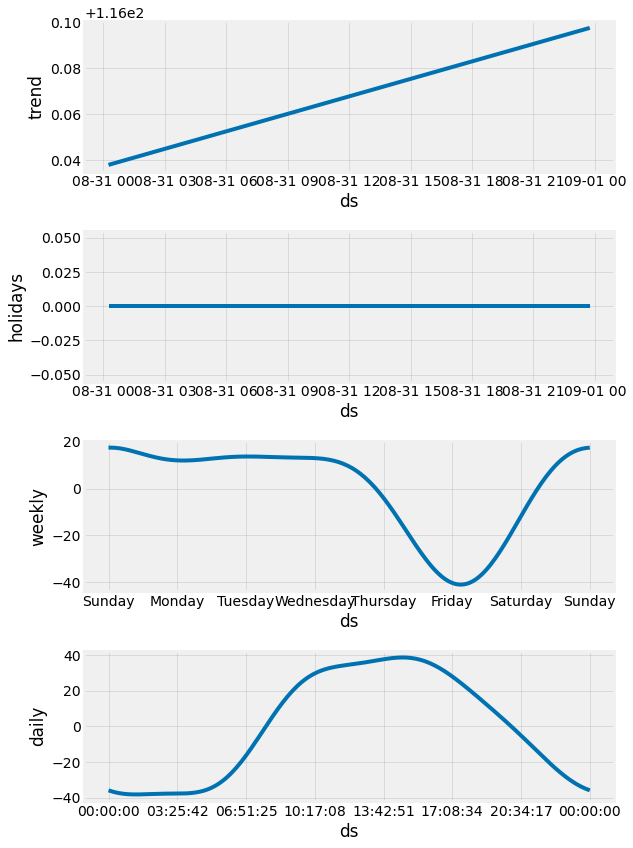

In [324]:
fig2 = model_with_holidays.plot_components(test_fcst_with_hols)

In [325]:
mean_squared_error(y_true=test['load'],
                   y_pred=test_fcst_with_hols['yhat'])

547.6016834356475

In [326]:
mean_absolute_error(y_true=test['load'],
                   y_pred=test_fcst_with_hols['yhat'])

21.084216291462162

In [327]:
mean_absolute_percentage_error(y_true=test['load'],
                   y_pred=test_fcst_with_hols['yhat'])

27.593752252939048

### Analysis

- From the Error analysis for the one day ahead forecasting considering holidays, we see that since the testing size is small, we do not see much changes in the error analysis.

- If the same analysis was performed on a longer term (1 week to 1 month) forecasting, an improvement in accuracy can be expected.

- It would also be interesting to investigate weekdays and weekend load profile.

- In further modeling and analysis, a single model will perform better if along with seasonality, trend, we include exogenous variables into modeling.

- An LSTM based approach would also help in revealing more adequate forecasting especially with parameter tuning.